# Unit 4 Unsupervised Learning Capstone Project

## Imports

In [1]:
#Basic imports 
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re

#NLP imports 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en')
from sklearn.feature_extraction.text import TfidfVectorizer

#Dimension Reduction 
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer

#Clustering 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

#Clustering Evaluation 
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

#Model Imports  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#Model Optimization 
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV 

#Time
import time 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Upload, Review, and Cleaning

In [0]:
df = pd.read_csv('https://www.dropbox.com/s/d4ye48a67tth2ae/Reviews.csv?dl=1')

In [3]:
#drop uneccessary columns 
df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time', 'Summary'],axis=1,inplace=True)
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
Score    568454 non-null int64
Text     568454 non-null object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [5]:
df.isnull().sum()

Score    0
Text     0
dtype: int64

In [0]:
# Remove duplicate reviews  
df.drop_duplicates(subset=['Score','Text'],keep='first',inplace=True)  

In [7]:

df.Score.value_counts()

5    250745
4     56074
1     36280
3     29772
2     20804
Name: Score, dtype: int64

In [0]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    
    text = re.sub(r'--',' ',text)
    
    # Removes hyperlinks 
    text = re.sub(r'<a\s+href=(?:"([^"]+)"|\'([^\']+)\').*?>(.*?)</a>',' ', text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    # Lowercase text
    text = text.lower()
    
    return text

In [0]:
df['Clean'] = df['Text'].apply(lambda x: text_cleaner(x))

In [0]:
# Create Utility function to lemmatize our text reviews limiting variations on same words
lemma = spacy.lang.en.English()

def lemma_text(text):
    tokens = lemma(text) 
    return([token.lemma_ for token in tokens if not token.is_punct and not token.is_stop])

df['lemma_text'] = df.Clean.apply(lemma_text)

In [11]:
df.head()

,Score,Text,Clean,lemma_text
0,5,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,"[buy, vitality, can, dog, food, product, find,..."
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,"[product, arrive, label, jumbo, salt, peanut, ..."
2,4,This is a confection that has been around a fe...,this is a confection that has been around a fe...,"[confection, century, light, pillowy, citrus, ..."
3,2,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,"[look, secret, ingredient, robitussin, believe..."
4,5,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wide...,"[great, taffy, great, price, wide, assortment,..."


## Feature Generation 

In [0]:
# Identifying variables
X = df['Clean']
y = df['Score']

# Splitting into train and test sets, reserve 25% for test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [0]:
# Total word count 
feature_df = pd.DataFrame()
feature_df['word_count'] = [len(x.split()) for x in X_train.tolist()]

# Count of punctuations 
feature_df['exclamation_marks'] = X_train.str.findall(r'[!]').str.len()
feature_df['periods'] = X_train.str.findall(r'[.]').str.len()
feature_df['question_marks'] = X_train.str.findall(r'[?]').str.len()
feature_df['Text'] = X_train
feature_df['Score'] = y_train

In [14]:
# Loop through text for word positions 
for row in X_train: 
  tokens = lemma(row)
  noun = 0
  verb = 0
  adj = 0
  proper = 0 
  for token in tokens:
   # Identifying each part of speech and adding to counts
    if token.pos_ == 'NOUN':
      noun +=1
    elif token.pos_ == 'VERB':
      verb +=1
    elif token.pos_ == 'ADJ':
      adj +=1   
    elif token.pos_ == 'PROPN':
      proper +=1
    # Creating a list of all features for each sentence
    feature_df.append([noun, verb, adj, proper])


/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


KeyboardInterrupt: ignored

In [14]:
# Let's check our new features
feature_df.head()

,word_count,exclamation_marks,periods,question_marks,Text,Score
0,22,0.0,3.0,0.0,i have bought several of the vitality canned d...,5.0
1,78,0.0,5.0,0.0,product arrived labeled as jumbo salted peanut...,1.0
2,24,0.0,9.0,0.0,this is a confection that has been around a fe...,4.0
3,37,0.0,3.0,0.0,if you are looking for the secret ingredient i...,2.0
4,56,0.0,4.0,0.0,great taffy at a great price. there was a wide...,5.0


In [19]:
# Initialize vectorizer 
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             tokenizer=lemma_text)


# Applying the vectorizer
X_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

# Splitting into train and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

# Reshape vectorizer to readable content
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Number of paragraphs
n = X_train_tfidf_csr.shape[0]

# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 70088


KeyError: ignored

## Dimensionality Reduction

In [20]:
#Our SVD data reducer.  We are going to reduce the feature space from upwards of 70k to 150.
svd= TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 25.6517784562051
Component 0:
Clean
skor bars were a gift to my son; they are his favorite. hard to find on the open market place. no need to say he loved the gift!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 0.699443
this is the same product sold in the 'brick and mortar' stores for much more $$$$. i keep it on auto-buy. it 

In [21]:
tfidf_df = pd.DataFrame(data=X_train_lsa)
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.219359,-0.083756,-0.026249,-0.055444,0.073780,0.279669,0.130958,0.175923,0.086169,0.129219,...,-0.034766,0.053317,0.052316,-0.026100,0.058576,0.038641,0.041538,-0.031569,0.017604,0.013154
1,0.448277,-0.164867,-0.058756,-0.056759,-0.090661,0.178492,-0.021675,-0.084486,0.028504,0.118611,...,-0.033832,0.054194,-0.055066,0.072192,0.013214,-0.037455,0.011321,-0.046787,-0.018572,0.012482
2,0.512499,-0.207826,-0.046787,0.035122,0.090633,0.148265,-0.054061,0.066485,0.145101,-0.123818,...,0.083230,-0.007808,0.050956,0.013355,0.065961,0.082175,-0.025672,0.055612,0.037891,-0.125265
3,0.249003,-0.097598,-0.012913,-0.151648,-0.017880,-0.254350,0.157916,0.159583,0.199956,-0.056765,...,-0.017753,0.048171,-0.021298,-0.018937,0.017248,-0.004006,0.039017,-0.041930,-0.032496,-0.023979
4,0.369391,-0.103716,-0.033122,0.004461,-0.053811,-0.062152,-0.004741,0.041748,-0.062890,0.096111,...,-0.030254,-0.037054,0.156774,-0.082027,0.023334,0.014758,0.022908,-0.108371,0.049545,-0.015205


In [22]:
new_df = pd.concat([tfidf_df, feature_df], ignore_index=False, axis=1)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,word_count,exclamation_marks,periods,question_marks,Text,Score
0,0.219359,-0.083756,-0.026249,-0.055444,0.073780,0.279669,0.130958,0.175923,0.086169,0.129219,...,0.041538,-0.031569,0.017604,0.013154,22,0.0,3.0,0.0,i have bought several of the vitality canned d...,5.0
1,0.448277,-0.164867,-0.058756,-0.056759,-0.090661,0.178492,-0.021675,-0.084486,0.028504,0.118611,...,0.011321,-0.046787,-0.018572,0.012482,78,0.0,5.0,0.0,product arrived labeled as jumbo salted peanut...,1.0
2,0.512499,-0.207826,-0.046787,0.035122,0.090633,0.148265,-0.054061,0.066485,0.145101,-0.123818,...,-0.025672,0.055612,0.037891,-0.125265,24,0.0,9.0,0.0,this is a confection that has been around a fe...,4.0
3,0.249003,-0.097598,-0.012913,-0.151648,-0.017880,-0.254350,0.157916,0.159583,0.199956,-0.056765,...,0.039017,-0.041930,-0.032496,-0.023979,37,0.0,3.0,0.0,if you are looking for the secret ingredient i...,2.0
4,0.369391,-0.103716,-0.033122,0.004461,-0.053811,-0.062152,-0.004741,0.041748,-0.062890,0.096111,...,0.022908,-0.108371,0.049545,-0.015205,56,0.0,4.0,0.0,great taffy at a great price. there was a wide...,5.0


## Clustering

In [0]:
# Convert our nan values to zeros for clustering 
new_df.replace('NaN', np.nan) 
new_df.fillna(0, inplace=True)

### K Means

In [0]:
# Declare clustering variables  
cluster_features = new_df.drop(['Score','Text'], axis=1)
cluster_predict = new_df['Score']

In [25]:
# Clustering algorithms need normalization
scalar = MinMaxScaler()

cluster_scaled = scalar.fit_transform(cluster_features)
cluster_df = pd.DataFrame(cluster_scaled)
X_pca = PCA(2).fit_transform(cluster_df)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
#from sklearn.preprocessing import normalize
# Normalize data for clustering purposes 
#cluster_norm = normalize(cluster_features) 
#print(len(cluster_norm))

# Reduce components for visualizations 
#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(cluster_norm)

295256


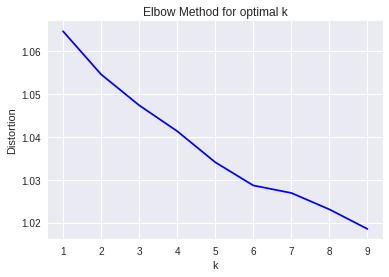

In [30]:
# Let's see what the elbow curve tells us would be the optimal K value 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(cluster_scaled)
    kmeanModel.fit(cluster_scaled)
    distortions.append(sum(np.min(cdist(cluster_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cluster_scaled.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

In [33]:
# Declare and fit clustering model using K of 6 for our 6 scores
kmeans = KMeans(n_clusters=6, random_state=0)
y_pred = kmeans.fit_predict(cluster_scaled)

pd.crosstab(cluster_predict, y_pred)

col_0,0,1,2,3,4,5
Score,,,,,,
0.0,8565,10442,10518,6749,32808,54228
1.0,1139,1318,1345,879,4239,6954
2.0,650,731,768,507,2475,4148
3.0,969,1159,1171,690,3497,5875
4.0,1697,2011,2247,1349,6724,10948
5.0,7626,9186,9265,5928,29010,47441


In [34]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(cluster_predict, y_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(cluster_scaled, y_pred, metric='euclidean')))

Adjusted Rand Score: -0.00019245
Silhouette Score: -0.00091741


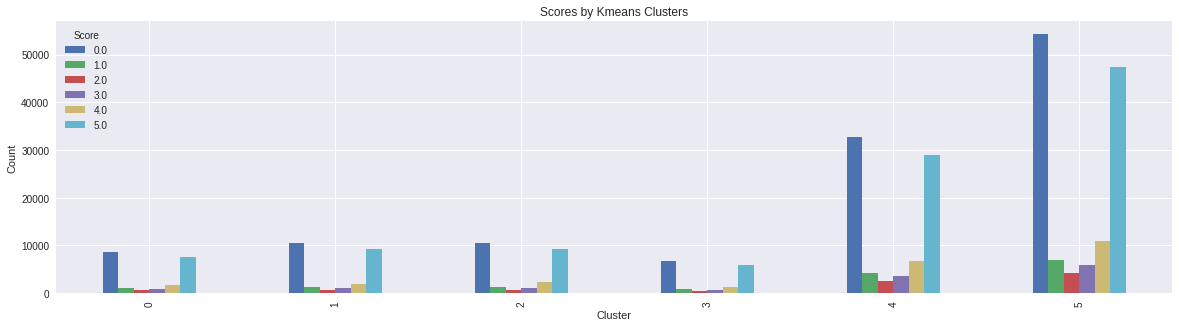

In [35]:
#Show scores categorized by cluster
prediction = pd.crosstab(y_pred, cluster_predict)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Scores by Kmeans Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Bandwidth 

Due to the size of the dataset, we won't be using bandwidth as a clustering method here. 

In [36]:
# Declare and fit the model ***Crashed session 
bandwidth = estimate_bandwidth(cluster_scaled, quantile=0.3)
meanshift_pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(cluster_scaled)

pd.crosstab(cluster_predict, meanshift_pred)

KeyboardInterrupt: ignored

In [0]:
# Get ARI and Silhouette Score
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(cluster_predict, meanshift_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(cluster_scaled, meanshift_pred, metric='euclidean')))

In [0]:
#Show scores categorized by cluster
prediction = pd.crosstab(meanshift_pred, cluster_predict)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Scores by Mean Shift Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Spectral Clustering

In [0]:
# Declare and fit the model ***Crashed session 
sc = SpectralClustering(n_clusters=6)
spectral_pred = sc.fit_predict(cluster_scaled)

pd.crosstab(cluster_predict, spectral_pred)

In [0]:
# Get ARI and Silhouette Score 
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(cluster_predict, spectral_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(cluster_scaled, spectral_pred, metric='euclidean')))

In [0]:
#Show scores categorized by cluster
prediction = pd.crosstab(spectral_pred, cluster_predict)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Scores by Spectral Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Affinity Propogation 

In [0]:
# Declare and fit model ***Crashed session 
ap = AffinityPropagation()
affinity_pred = ap.fit_predict(cluster_scaled)

pd.crosstab(cluster_predict, affinity_pred)

In [0]:
# Get ARI and Silhouette Score 
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(cluster_predict, affinity_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(cluster_scaled, affinity_pred, metric='euclidean')))

## Modeling Training Set

In [26]:
lr = LogisticRegression()
train = lr.fit(cluster_scaled, cluster_predict)
lr_scores = cross_val_score(lr, cluster_scaled, cluster_predict, cv=5)

print('\nCross Validation Training Scores:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed


Cross Validation Training Scores:0.66478(+/- 0.003)


In [27]:
rfc = RandomForestClassifier()
train = rfc.fit(cluster_scaled, cluster_predict)
rfc_scores = cross_val_score(rfc, cluster_scaled, cluster_predict, cv=5)

print('\nCross Validation Training Scores:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Cross Validation Training Scores:0.75564(+/- 0.001)


In [0]:
gb = ensemble.GradientBoostingClassifier()
train = gb.fit(cluster_scaled, cluster_predict)
gb_scores = cross_val_score(gb, cluster_scaled, cluster_predict, cv=5)

print('\nCross Validation Training Scores:{:.5f}(+/- {:.3f})'.format(gb_scores.mean(), gb_scores.std()*2))

## Modeling Test Holdout Group 

We'll need to process the test group as we did the training set above. 

In [0]:
# Total word count 
feature_df_test = pd.DataFrame()
feature_df_test['word_count'] = [len(x.split()) for x in X_test.tolist()]

# Count of punctuations 
feature_df_test['exclamation_marks'] = X_test.str.findall(r'[!]').str.len()
feature_df_test['periods'] = X_test.str.findall(r'[.]').str.len()
feature_df_test['question_marks'] = X_test.str.findall(r'[?]').str.len()
feature_df_test['Text'] = X_test
feature_df_test['Score'] = y_test

In [0]:
# Loop through text for word positions 
for row in X_test: 
  tokens = lemma(row)
  noun = 0
  verb = 0
  adj = 0
  proper = 0 
  for token in tokens:
   # Identifying each part of speech and adding to counts
    if token.pos_ == 'NOUN':
      noun +=1
    elif token.pos_ == 'VERB':
      verb +=1
    elif token.pos_ == 'ADJ':
      adj +=1   
    elif token.pos_ == 'PROPN':
      proper +=1
    # Creating a list of all features for each sentence
    feature_df_test.append([noun, verb, adj, proper])

In [0]:
#Our SVD data reducer.  We are going to reduce the feature space to 150 again for test.
svd= TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

In [0]:
tfidf_df_test = pd.DataFrame(data=X_test_lsa)
tfidf_df_test.head()

In [0]:
new_df_test = pd.concat([tfidf_df_test, feature_df_test], ignore_index=False, axis=1)
new_df_test.head()

In [0]:
# Convert our nan values to zeros
new_df_test.replace('NaN', np.nan) 
new_df_test.fillna(0, inplace=True)
# Declare variables  
test_features = new_df.drop(['Score','Text'], axis=1)
test_predict = new_df['Score']
# Normalize data 
scalar = MinMaxScaler()

test_scaled = scalar.fit_transform(test_features)
test_df = pd.DataFrame(test_scaled)

In [0]:
# Declare and fit clustering model for test using K of 6 for our 6 scores
kmeans = KMeans(n_clusters=6, random_state=0)
y_pred = kmeans.fit_predict(test_scaled)

pd.crosstab(test_predict, y_pred)

In [0]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(test_predict, y_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(test_scaled, y_pred, metric='euclidean')))

In [0]:
#Show scores categorized by cluster
prediction = pd.crosstab(y_pred, test_predict)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Scores by Kmeans Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [0]:
#initialize best performing model above to test set 

## Conclusion

## Future Work

optimize parameters in clusters 

optimize parameters in models
